# Gradient Boosting Model Development and Evaluation

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
import joblib
import os
import sys
import shutil
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
from collections import defaultdict



## Adding path for custom python modules and importing them

In [2]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from utilities import bs_calibrate, bs_results, utils

## DATA PREPARATION

In [4]:
df = pd.read_csv("../dibh_clinical_only/original_training_data.csv")
data_day1 = df[df['day'] == 1]
X = data_day1.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y = data_day1['DIBH_Y0N1']
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.30, random_state=42)

df_internal_val = pd.read_csv("../dibh_clinical_only/final_internal_validation13052024.csv")
data_day1_val = df_internal_val[df_internal_val['day'] == 1]
X_int_val = data_day1_val.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y_int_val = data_day1_val['DIBH_Y0N1']

categorical_features = ['al_N0_Y1', 'surgery_BCS1MRM2', 'chemo_No0_Adj1_NAdj2', 'comorb_no0_cardio1_others2']
continuous_features = ['age', 'BMI', 'ul_amp', 'll_amp', 'average_amp', 'ahd']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, continuous_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# HYPERPARAMETER OPTIMIZATION

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }
    gb_clf = make_pipeline(preprocessor, GradientBoostingClassifier(**params, random_state=42))
    cv_roc_auc = cross_val_score(gb_clf, X_t, y_t, cv=10, scoring='roc_auc').mean()
    return cv_roc_auc

In [ ]:
# storage_name = "sqlite:///db.sqlite3"
# sampler = TPESampler(seed=72)
# # Random seeds - 42,50,58,66,72
# study = optuna.create_study(direction='maximize', sampler=sampler, storage=storage_name, study_name="GB_one_day_assessment_final04")
# study.optimize(objective, n_trials=1000)

In [ ]:
storage_name = "sqlite:///db.sqlite3"
loaded_study = optuna.create_study(study_name="GB_one_day_assessment_final02", storage=storage_name, load_if_exists=True)
best_params = loaded_study.best_params

## Bootstraping and Calibration

In [ ]:
# For Gradient Boosting
top_models_gb, results_gb, calibration_data_gb = bs_calibrate.bootstrap_model_evaluation(
    X_t, y_t, X_v, y_v, preprocessor, GradientBoostingClassifier, best_params
)

## Saving Data

In [ ]:
joblib.dump(top_models_gb, '../GB_Models/top_models_gb.joblib')
joblib.dump(results_gb, '../GB_Models/results.joblib')
joblib.dump(calibration_data_gb, '../GB_Models/calibration_data_gb.joblib')

## Plotting calibration curves

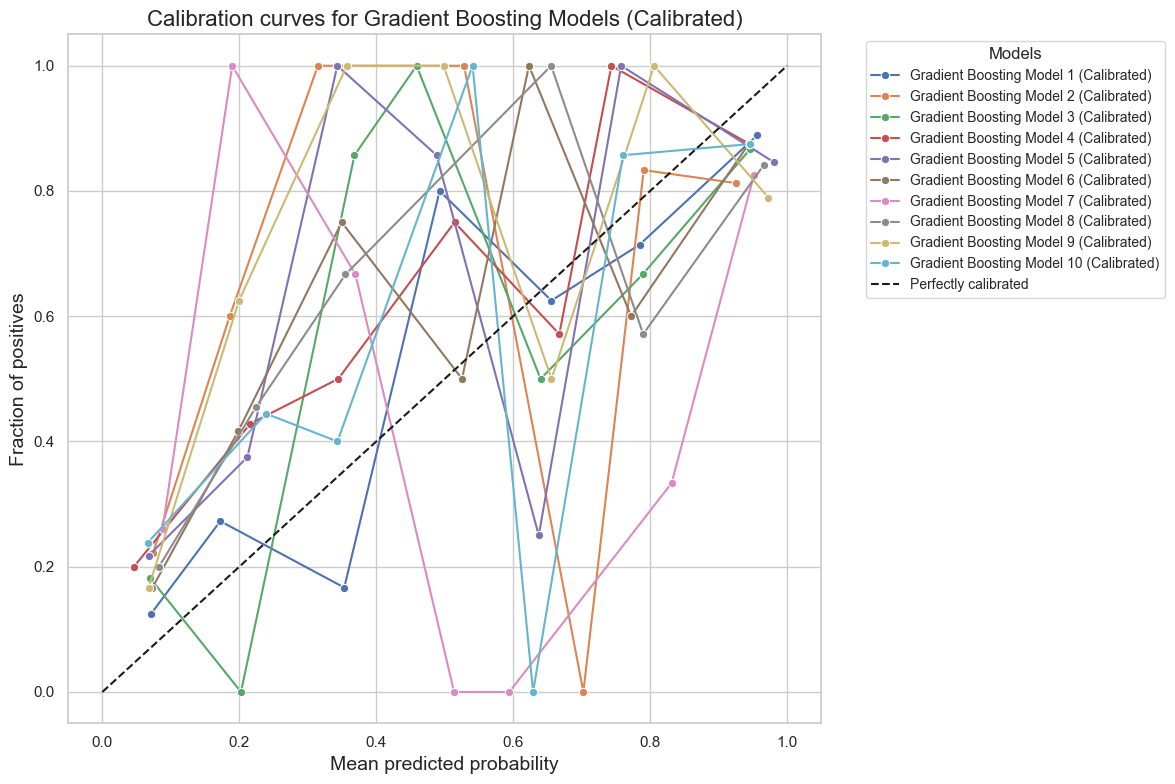

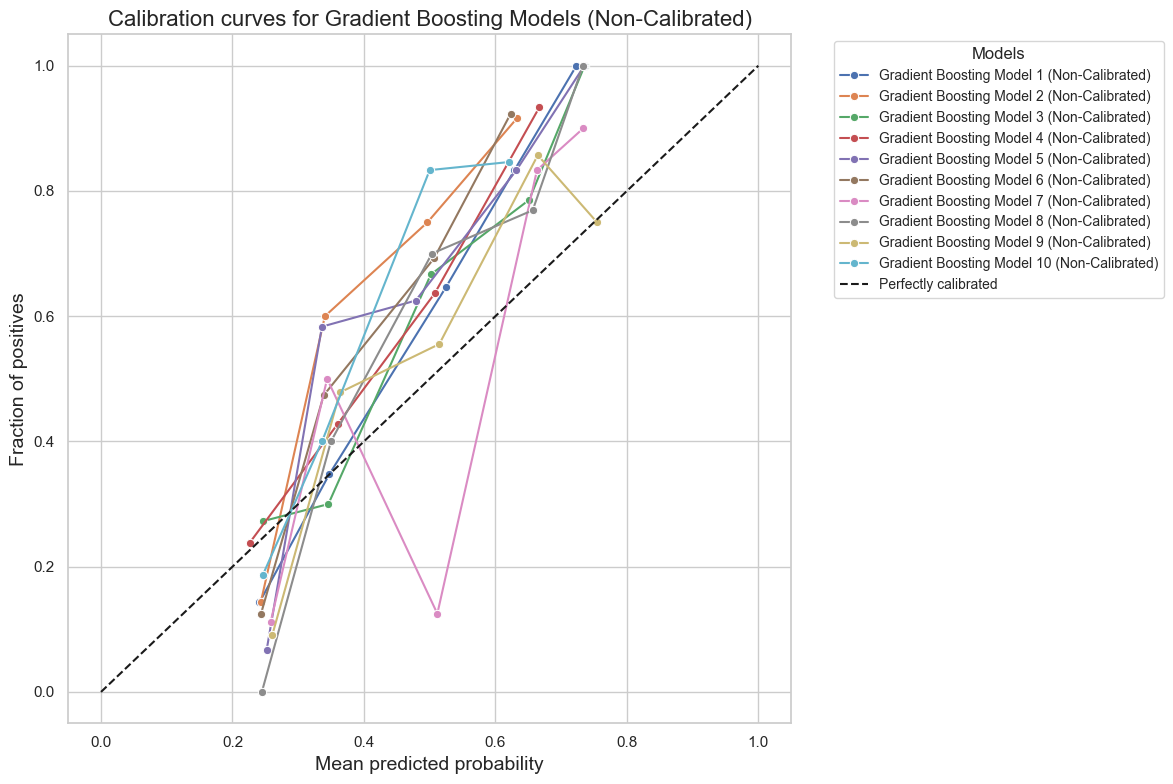

In [5]:
# Assuming calibration_data_gb and calibration_data_cat have the top 10 predicted probabilities
# for Gradient Boosting models
loaded_calibration_data = joblib.load('../GB_Models/calibration_data_gb.joblib')
# Example: Plotting calibration curves for top 10 Gradient Boosting models
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_calibrated'], n_bins=7, model_label="Gradient Boosting", calibrated=True)
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_non_calibrated'], n_bins=7, model_label="Gradient Boosting", calibrated=False)



## Extract feature importances and save them in a csv file

In [7]:
# Save to CSV
df_importances = utils.save_feature_importances_to_csv(filename='feature_importances.csv', 
                                                       model_name_prefix='gb', 
                                                       top_models_path="../GB_Models/top_models_gb.joblib")

Data saved to - feature_importances.csv


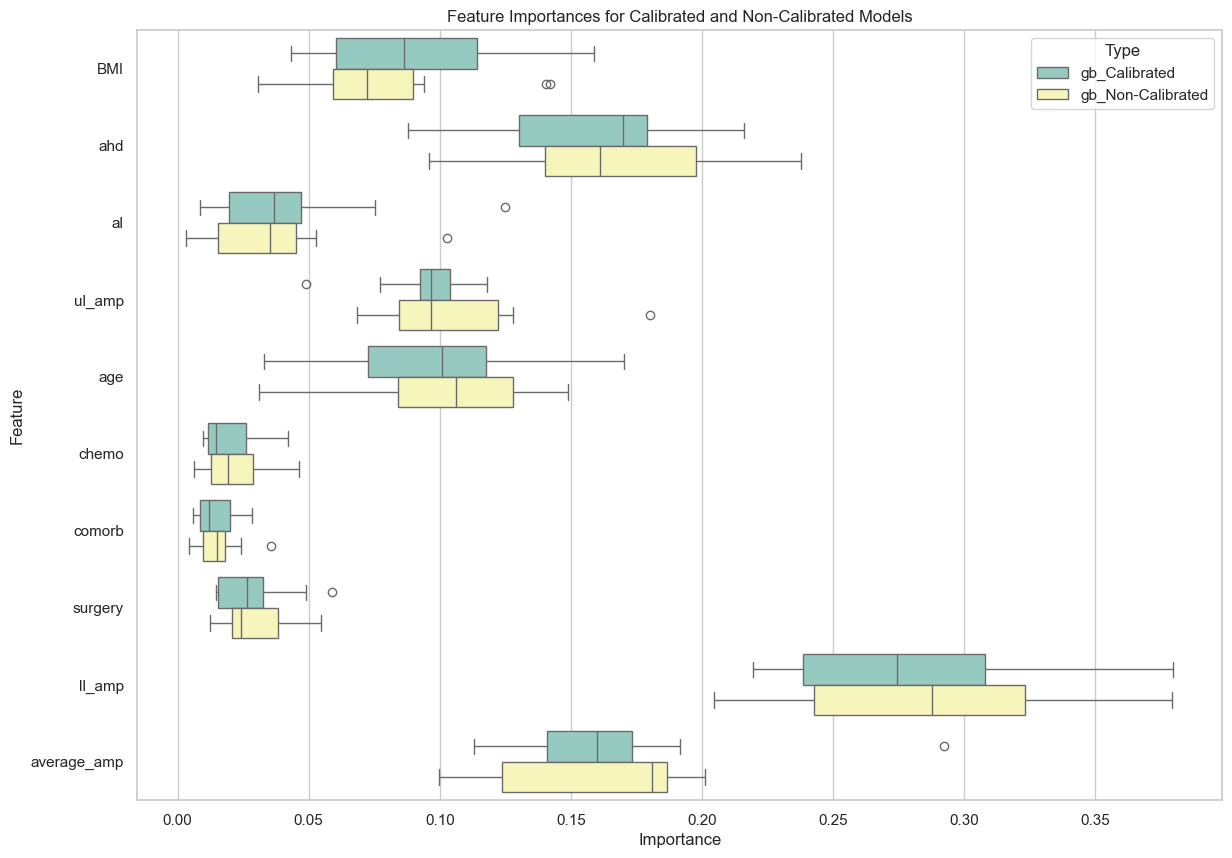

In [8]:
# Box plot
plt.figure(figsize=(14, 10))
sns.boxplot(x='Importance', y='Feature', hue='Type', data=df_importances, palette='Set3')
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

## Store the results for models into a csv file

In [ ]:
loaded_results = joblib.load('../GB_Models/results.joblib')
calibrated_summary, non_calibrated_summary = bs_results.get_results(loaded_results)

In [ ]:
filename='../saved_models/final_results.csv'
model_name = 'GB'
bs_results.save_results_to_csv(calibrated_summary, non_calibrated_summary, filename=filename, model_name=model_name)

In [ ]:
# Initialize lists to store results
top_models = []
fraction_of_positives_calibrated_list = []
mean_predicted_value_calibrated_list = []
fraction_of_positives_non_calibrated_list = []
mean_predicted_value_non_calibrated_list = []
results = []
# Number of bins for more granularity
n_bins_non_calibrated = 6
n_bins_calibrated = 6
for i in range(1000):
    X_resampled, y_resampled = resample(X_t, y_t)
    X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2)

    # Non-calibrated model
    gb_pipeline = make_pipeline(preprocessor, GradientBoostingClassifier(**best_params, random_state=42))
    gb_pipeline.fit(X_train_resampled, y_train_resampled)
    y_proba_non_calibrated = gb_pipeline.predict_proba(X_v)[:, 1]

    # Calibrated model
    best_gb_pipeline = make_pipeline(preprocessor, GradientBoostingClassifier(**best_params, random_state=42))
    best_gb_pipeline.fit(X_train_resampled, y_train_resampled)  # Fit the underlying pipeline first
    model = CalibratedClassifierCV(best_gb_pipeline, method='isotonic', cv=10)
    model.fit(X_train_resampled, y_train_resampled)
    y_proba_calibrated = model.predict_proba(X_v)[:, 1]

    # Verify that the models are fitted
    try:
        check_is_fitted(gb_pipeline.named_steps['gradientboostingclassifier'])
    except NotFittedError:
        print(f"GradientBoostingClassifier in non-calibrated pipeline is not fitted. Skipping this model.")
        continue

    try:
        check_is_fitted(model)
    except NotFittedError:
        print(f"CalibratedClassifierCV is not fitted. Skipping this model.")
        continue

    # Calibration curves for non-calibrated model
    fraction_of_positives_non_calibrated, mean_predicted_value_non_calibrated = calibration_curve(y_v, y_proba_non_calibrated, n_bins=n_bins_non_calibrated)
    if len(fraction_of_positives_non_calibrated) == n_bins_non_calibrated:
        print(f"FRACTION OF POSITIVE NON CALIBRATED: {fraction_of_positives_non_calibrated}")
        fraction_of_positives_non_calibrated_list.append(fraction_of_positives_non_calibrated)
        mean_predicted_value_non_calibrated_list.append(mean_predicted_value_non_calibrated)
    else:
        print(f"Non-calibrated model - Unexpected number of bins: {len(fraction_of_positives_non_calibrated)}")

    # Calibration curves for calibrated model
    fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_v, y_proba_calibrated, n_bins=n_bins_calibrated)
    if len(fraction_of_positives_calibrated) == n_bins_calibrated:
        print(f"FRACTION OF POSITIVE CALIBRATED: {fraction_of_positives_calibrated}")
        fraction_of_positives_calibrated_list.append(fraction_of_positives_calibrated)
        mean_predicted_value_calibrated_list.append(mean_predicted_value_calibrated)
    else:
        print(f"Calibrated model - Unexpected number of bins: {len(fraction_of_positives_calibrated)}")

    # ROC curve and other metrics for calibrated model
    fpr, tpr, thresholds = roc_curve(y_v, y_proba_calibrated)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_optimal = (y_proba_calibrated >= optimal_threshold).astype(int)

    # ROC curve and other metrics for non-calibrated model
    fpr_non_calibrated, tpr_non_calibrated, thresholds_non_calibrated = roc_curve(y_v, y_proba_non_calibrated)
    roc_auc_non_calibrated = auc(fpr_non_calibrated, tpr_non_calibrated)
    optimal_idx_non_calibrated = np.argmax(tpr_non_calibrated - fpr_non_calibrated)
    optimal_threshold_non_calibrated = thresholds_non_calibrated[optimal_idx_non_calibrated]
    y_pred_optimal_non_calibrated = (y_proba_non_calibrated >= optimal_threshold_non_calibrated).astype(int)

    # Extract feature importances and names for non-calibrated model
    pipeline_non_calibrated = gb_pipeline
    gradient_boosting_non_calibrated = pipeline_non_calibrated.named_steps['gradientboostingclassifier']
    feature_importances_non_calibrated = gradient_boosting_non_calibrated.feature_importances_
    preprocessor = pipeline_non_calibrated.named_steps['columntransformer']
    feature_names = preprocessor.get_feature_names_out()

    # Aggregate importances for one-hot encoded features for non-calibrated model
    aggregated_importances_non_calibrated = defaultdict(float)
    for feature_name, importance in zip(feature_names, feature_importances_non_calibrated):
        original_feature_name = feature_name.split('__')[1].split('_')[0] if 'cat__' in feature_name else feature_name.split('__')[1]
        aggregated_importances_non_calibrated[original_feature_name] += importance

    # Convert aggregated importances to a sorted list of tuples for non-calibrated model
    sorted_importances_non_calibrated = sorted(aggregated_importances_non_calibrated.items(), key=lambda x: x[1], reverse=True)

    # Extract feature importances and names for calibrated model
    pipeline_calibrated = model.estimator
    gradient_boosting_calibrated = pipeline_calibrated.named_steps['gradientboostingclassifier']
    feature_importances_calibrated = gradient_boosting_calibrated.feature_importances_

    # Aggregate importances for one-hot encoded features for calibrated model
    aggregated_importances_calibrated = defaultdict(float)
    for feature_name, importance in zip(feature_names, feature_importances_calibrated):
        original_feature_name = feature_name.split('__')[1].split('_')[0] if 'cat__' in feature_name else feature_name.split('__')[1]
        aggregated_importances_calibrated[original_feature_name] += importance

    # Convert aggregated importances to a sorted list of tuples for calibrated model
    sorted_importances_calibrated = sorted(aggregated_importances_calibrated.items(), key=lambda x: x[1], reverse=True)

    model_info = {
        'model_calibrated': model,
        'fpr_calibrated': fpr,
        'tpr_calibrated': tpr,
        'thresholds_calibrated': thresholds,
        'roc_auc_calibrated': roc_auc,
        'optimal_threshold_calibrated': optimal_threshold,
        'accuracy_calibrated': accuracy_score(y_v, y_pred_optimal),
        'precision_calibrated': precision_score(y_v, y_pred_optimal),
        'recall_calibrated': recall_score(y_v, y_pred_optimal),
        'f1_score_calibrated': f1_score(y_v, y_pred_optimal),
        'confusion_matrix_calibrated': confusion_matrix(y_v, y_pred_optimal),
        'classification_report_calibrated': classification_report(y_v, y_pred_optimal),
        'feature_importances_calibrated': sorted_importances_calibrated,
        'model_non_calibrated': gb_pipeline,
        'fpr_non_calibrated': fpr_non_calibrated,
        'tpr_non_calibrated': tpr_non_calibrated,
        'thresholds_non_calibrated': thresholds_non_calibrated,
        'roc_auc_non_calibrated': roc_auc_non_calibrated,
        'optimal_threshold_non_calibrated': optimal_threshold_non_calibrated,
        'accuracy_non_calibrated': accuracy_score(y_v, y_pred_optimal_non_calibrated),
        'precision_non_calibrated': precision_score(y_v, y_pred_optimal_non_calibrated),
        'recall_non_calibrated': recall_score(y_v, y_pred_optimal_non_calibrated),
        'f1_score_non_calibrated': f1_score(y_v, y_pred_optimal_non_calibrated),
        'confusion_matrix_non_calibrated': confusion_matrix(y_v, y_pred_optimal_non_calibrated),
        'classification_report_non_calibrated': classification_report(y_v, y_pred_optimal_non_calibrated),
        'feature_importances_non_calibrated': sorted_importances_non_calibrated
    }

    # Add the non-model info to results
    model_info_without_model = {key: value for key, value in model_info.items() if not key.startswith('model')}
    results.append(model_info_without_model)

    # Keep top 10 models based on calibrated ROC AUC
    if len(top_models) < 10:
        top_models.append(model_info)
    else:
        min_index = min(range(len(top_models)), key=lambda x: (top_models[x]['roc_auc_calibrated'], top_models[x]['recall_calibrated']))
        if roc_auc > top_models[min_index]['roc_auc_calibrated']:
            top_models[min_index] = model_info
    if (i + 1) % 25 == 0:
        print(f"Bootstrap sample no. {i + 1} ------ Finished")

In [ ]:
joblib.dump(top_models, 'top_models_with_importances.joblib')
joblib.dump(results, 'results.joblib')

In [ ]:
# Collect feature importances for both calibrated and non-calibrated models
loaded_top_models = joblib.load('top_models_with_importances.joblib')
calibrated_importances = []
non_calibrated_importances = []
feature_names = set()

for model_info in loaded_top_models:
    calibrated_importances.append(dict(model_info['feature_importances_calibrated']))
    non_calibrated_importances.append(dict(model_info['feature_importances_non_calibrated']))
    feature_names.update([name for name, _ in model_info['feature_importances_calibrated']])
    feature_names.update([name for name, _ in model_info['feature_importances_non_calibrated']])

# Create a DataFrame for easier plotting
feature_importance_data = []
for name in feature_names:
    for imp in calibrated_importances:
        if name in imp:
            feature_importance_data.append({'Feature': name, 'Importance': imp[name], 'Type': 'Calibrated'})
    for imp in non_calibrated_importances:
        if name in imp:
            feature_importance_data.append({'Feature': name, 'Importance': imp[name], 'Type': 'Non-Calibrated'})

df_importances = pd.DataFrame(feature_importance_data)

# Box plot
plt.figure(figsize=(14, 10))
sns.boxplot(x='Importance', y='Feature', hue='Type', data=df_importances, palette='Set3')
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

In [ ]:
# Violin plot
plt.figure(figsize=(14, 10))
sns.violinplot(x='Importance', y='Feature', hue='Type', data=df_importances, split=True, inner='quart', palette='Set2')
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

In [ ]:
# Swarm plot
plt.figure(figsize=(14, 10))
sns.swarmplot(x='Importance', y='Feature', hue='Type', data=df_importances, palette='Set1', dodge=True)
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

In [ ]:
# Strip plot with jitter
plt.figure(figsize=(14, 10))
sns.stripplot(x='Importance', y='Feature', hue='Type', data=df_importances, palette='Set2', jitter=True, dodge=True)
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

In [ ]:
# Calculate the mean importance for each feature
mean_importances = df_importances.groupby(['Feature', 'Type']).mean().reset_index()

# Bar plot
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', hue='Type', data=mean_importances, palette='Set3')
plt.title('Mean Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

In [ ]:
# Pivot the data for heatmap
heatmap_data = df_importances.pivot_table(index='Feature', columns='Type', values='Importance', aggfunc='mean')

# Heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Mean Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

In [ ]:
# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Separate metrics for calibrated and non-calibrated models
calibrated_metrics = df_results[['accuracy_calibrated', 'precision_calibrated', 'recall_calibrated', 'f1_score_calibrated', 'roc_auc_calibrated']]
non_calibrated_metrics = df_results[['accuracy_non_calibrated', 'precision_non_calibrated', 'recall_non_calibrated', 'f1_score_non_calibrated', 'roc_auc_non_calibrated']]

# Calculate summary statistics for calibrated metrics
calibrated_summary = calibrated_metrics.agg(['mean', 'std', 'min', 'max'])
calibrated_summary.loc['95% CI lower'] = calibrated_summary.loc['mean'] - 1.96 * calibrated_summary.loc['std']
calibrated_summary.loc['95% CI upper'] = calibrated_summary.loc['mean'] + 1.96 * calibrated_summary.loc['std']

# Calculate summary statistics for non-calibrated metrics
non_calibrated_summary = non_calibrated_metrics.agg(['mean', 'std', 'min', 'max'])
non_calibrated_summary.loc['95% CI lower'] = non_calibrated_summary.loc['mean'] - 1.96 * non_calibrated_summary.loc['std']
non_calibrated_summary.loc['95% CI upper'] = non_calibrated_summary.loc['mean'] + 1.96 * non_calibrated_summary.loc['std']

# Rename columns for clarity
calibrated_summary.columns = [col.replace('_calibrated', '') for col in calibrated_summary.columns]
non_calibrated_summary.columns = [col.replace('_non_calibrated', '') for col in non_calibrated_summary.columns]

# Print the summaries
print("Calibrated Model Metrics Summary")
print(calibrated_summary)

print("\nNon-Calibrated Model Metrics Summary")
print(non_calibrated_summary)

# Optionally, save these summaries to CSV for further analysis or reporting
calibrated_summary.to_csv('calibrated_model_metrics_summary.csv')
non_calibrated_summary.to_csv('non_calibrated_model_metrics_summary.csv')

In [ ]:
def save_results_to_csv(calibrated_summary, non_calibrated_summary, model_name, filename='final_results.csv'):
    """
    Save the summary statistics of calibrated and non-calibrated models to a CSV file.
    
    Parameters:
    calibrated_summary (pd.DataFrame): Summary statistics for calibrated models.
    non_calibrated_summary (pd.DataFrame): Summary statistics for non-calibrated models.
    model_name (str): The name of the model to be prepended to each entry in the "Models" column.
    filename (str): The name of the CSV file. Default is 'final_results.csv'.
    """
    # Combine calibrated and non-calibrated summaries into one DataFrame
    combined_summary = pd.DataFrame({
        'Models': [f'{model_name}_Calibrated', f'{model_name}_Non_Calibrated'],
        'Accuracy': [calibrated_summary.loc['mean', 'accuracy'], non_calibrated_summary.loc['mean', 'accuracy']],
        'Acc_Std': [calibrated_summary.loc['std', 'accuracy'], non_calibrated_summary.loc['std', 'accuracy']],
        'Acc_95%CI': [
            f"{calibrated_summary.loc['95% CI lower', 'accuracy']} - {calibrated_summary.loc['95% CI upper', 'accuracy']}",
            f"{non_calibrated_summary.loc['95% CI lower', 'accuracy']} - {non_calibrated_summary.loc['95% CI upper', 'accuracy']}"
        ],
        'Precision': [calibrated_summary.loc['mean', 'precision'], non_calibrated_summary.loc['mean', 'precision']],
        'Precision_Std': [calibrated_summary.loc['std', 'precision'], non_calibrated_summary.loc['std', 'precision']],
        'Precision_95%CI': [
            f"{calibrated_summary.loc['95% CI lower', 'precision']} - {calibrated_summary.loc['95% CI upper', 'precision']}",
            f"{non_calibrated_summary.loc['95% CI lower', 'precision']} - {non_calibrated_summary.loc['95% CI upper', 'precision']}"
        ],
        'Recall': [calibrated_summary.loc['mean', 'recall'], non_calibrated_summary.loc['mean', 'recall']],
        'Recall_Std': [calibrated_summary.loc['std', 'recall'], non_calibrated_summary.loc['std', 'recall']],
        'Recall_95%CI': [
            f"{calibrated_summary.loc['95% CI lower', 'recall']} - {calibrated_summary.loc['95% CI upper', 'recall']}",
            f"{non_calibrated_summary.loc['95% CI lower', 'recall']} - {non_calibrated_summary.loc['95% CI upper', 'recall']}"
        ],
        'F1Score': [calibrated_summary.loc['mean', 'f1_score'], non_calibrated_summary.loc['mean', 'f1_score']],
        'F1Score_Std': [calibrated_summary.loc['std', 'f1_score'], non_calibrated_summary.loc['std', 'f1_score']],
        'F1Score_95%CI': [
            f"{calibrated_summary.loc['95% CI lower', 'f1_score']} - {calibrated_summary.loc['95% CI upper', 'f1_score']}",
            f"{non_calibrated_summary.loc['95% CI lower', 'f1_score']} - {non_calibrated_summary.loc['95% CI upper', 'f1_score']}"
        ],
        'AUC': [calibrated_summary.loc['mean', 'roc_auc'], non_calibrated_summary.loc['mean', 'roc_auc']],
        'AUC_std': [calibrated_summary.loc['std', 'roc_auc'], non_calibrated_summary.loc['std', 'roc_auc']],
        'AUC_95%CI': [
            f"{calibrated_summary.loc['95% CI lower', 'roc_auc']} - {calibrated_summary.loc['95% CI upper', 'roc_auc']}",
            f"{non_calibrated_summary.loc['95% CI lower', 'roc_auc']} - {non_calibrated_summary.loc['95% CI upper', 'roc_auc']}"
        ],
    })

    # Check if the file exists
    if os.path.exists(filename):
        # Append to the existing file
        combined_summary.to_csv(filename, mode='a', header=False, index=False)
    else:
        # Create a new file
        combined_summary.to_csv(filename, index=False)


In [ ]:
# Example usage
filename='../saved_models/final_results.csv'
model_name = 'gb'
save_results_to_csv(calibrated_summary, non_calibrated_summary, filename=filename, model_name=model_name)

In [ ]:
# Verify the calibration lists before calculating the means
print(f"Number of calibrated entries: {len(fraction_of_positives_calibrated_list)}")
print(f"Number of non-calibrated entries: {len(fraction_of_positives_non_calibrated_list)}")

# Calculate the mean fraction of positives and mean predicted values for calibrated models
mean_fraction_of_positives_calibrated = np.mean(fraction_of_positives_calibrated_list, axis=0)
mean_mean_predicted_value_calibrated = np.mean(mean_predicted_value_calibrated_list, axis=0)

# Calculate the mean fraction of positives and mean predicted values for non-calibrated models
mean_fraction_of_positives_non_calibrated = np.mean(fraction_of_positives_non_calibrated_list, axis=0)
mean_mean_predicted_value_non_calibrated = np.mean(mean_predicted_value_non_calibrated_list, axis=0)

# Debugging: print the means
print(f"Calibrated mean fraction of positives: {mean_fraction_of_positives_calibrated}")
print(f"Calibrated mean predicted value: {mean_mean_predicted_value_calibrated}")
print(f"Non-calibrated mean fraction of positives: {mean_fraction_of_positives_non_calibrated}")
print(f"Non-calibrated mean predicted value: {mean_mean_predicted_value_non_calibrated}")

# Interpolate to a common set of points for smoother comparison
common_points = np.linspace(0, 1, 100)
interp_fraction_of_positives_calibrated = np.interp(common_points, mean_mean_predicted_value_calibrated, mean_fraction_of_positives_calibrated)
interp_fraction_of_positives_non_calibrated = np.interp(common_points, mean_mean_predicted_value_non_calibrated, mean_fraction_of_positives_non_calibrated)

# Plot the calibration curves
plt.figure(figsize=[8, 6])
plt.plot(common_points, interp_fraction_of_positives_calibrated, "s-", label="Calibrated (bootstrap)")
plt.plot(common_points, interp_fraction_of_positives_non_calibrated, "o-", label="Non-Calibrated (bootstrap)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves using Bootstrapping")
plt.legend()
plt.show()

In [ ]:
from collections import defaultdict
import numpy as np

# Load the top models
top_models = joblib.load('top_models.joblib')

# Initialize a dictionary to accumulate feature importances
aggregated_importances = defaultdict(list)

# Collect feature importances from all top models
for model_info in top_models:
    feature_importances = model_info['feature_importances_non_calibrated']
    for feature, importance in feature_importances:
        aggregated_importances[feature].append(importance)

# Calculate the average feature importance for each feature
average_importances = {feature: np.mean(importances) for feature, importances in aggregated_importances.items()}

# Sort the features based on their average importance
sorted_importances = sorted(average_importances.items(), key=lambda x: x[1], reverse=True)

# Print or store the sorted feature importances
print("Sorted Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

# Optionally, plot the sorted feature importances
import matplotlib.pyplot as plt

features, importances = zip(*sorted_importances)
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance for Top Models')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

In [ ]:
# Load the top models
top_models = joblib.load('top_models.joblib')

# Initialize a dictionary to accumulate feature importances
aggregated_importances = defaultdict(list)

# Collect feature importances from all top models
for model_info in top_models:
    feature_importances = model_info['feature_importances_non_calibrated']
    for feature, importance in feature_importances:
        aggregated_importances[feature].append(importance)

# Align feature importances for each feature across all models
features = list(aggregated_importances.keys())
importances = [aggregated_importances[feature] for feature in features]

# Create a boxplot
plt.figure(figsize=(12, 8))
plt.boxplot(importances, vert=False, patch_artist=True, labels=features)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Top 10 Models')
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

# Example feature importances
features, importances = zip(*sorted_importances)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("coolwarm", len(features))
plt.barh(features, importances, color=colors)
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance for Top Models')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for heatmap
importance_df = pd.DataFrame(aggregated_importances)

plt.figure(figsize=(12, 8))
sns.heatmap(importance_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Importance'})
plt.title('Feature Importance Heatmap')
plt.xlabel('Models')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for stacked bar plot
importance_data = {feature: [0] * len(top_models) for feature in features}
for idx, model_info in enumerate(top_models):
    feature_importances = dict(model_info['feature_importances_non_calibrated'])
    for feature in features:
        importance_data[feature][idx] = feature_importances.get(feature, 0)

importance_df = pd.DataFrame(importance_data)

# Plot stacked bar plot
fig, ax = plt.subplots(figsize=(12, 8))
importance_df.plot(kind='barh', stacked=True, ax=ax, colormap='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Stacked Feature Importance for Top Models')
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

# Prepare data for violin plot
importance_list = []
for feature in features:
    for importance in aggregated_importances[feature]:
        importance_list.append([feature, importance])

importance_df = pd.DataFrame(importance_list, columns=['Feature', 'Importance'])

plt.figure(figsize=(12, 8))
sns.violinplot(x='Importance', y='Feature', data=importance_df, scale='width', palette='coolwarm')
plt.title('Feature Importance Distribution for Top Models')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Example feature importances
features, importances = zip(*sorted_importances)

plt.figure(figsize=(12, 8))
markerline, stemlines, baseline = plt.stem(features, importances, basefmt=" ")
plt.setp(markerline, marker='o', markersize=8, markeredgewidth=2)
plt.setp(stemlines, linewidth=2)
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance for Top Models')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for radar chart
labels = features
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))
for model_info in top_models:
    feature_importances = [dict(model_info['feature_importances_non_calibrated']).get(feature, 0) for feature in features]
    feature_importances += feature_importances[:1]
    ax.plot(angles, feature_importances, linewidth=1, linestyle='solid', label=f'Model {top_models.index(model_info) + 1}')
    ax.fill(angles, feature_importances, alpha=0.25)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('Feature Importance Radar Chart')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()

In [ ]:

# Load the top models
top_models = joblib.load('top_models.joblib')

# Initialize a dictionary to accumulate feature importances
aggregated_importances = defaultdict(list)

# Collect feature importances from all top models
for model_info in top_models:
    feature_importances = model_info['feature_importances_non_calibrated']
    for feature, importance in feature_importances:
        aggregated_importances[feature].append(importance)

# Calculate statistics
feature_stats = {}
for feature, importances in aggregated_importances.items():
    mean_importance = np.mean(importances)
    median_importance = np.median(importances)
    std_importance = np.std(importances)
    ci_lower = np.percentile(importances, 2.5)
    ci_upper = np.percentile(importances, 97.5)
    
    feature_stats[feature] = {
        'mean': mean_importance,
        'median': median_importance,
        'std': std_importance,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

# Convert to DataFrame for easier handling
feature_stats_df = pd.DataFrame(feature_stats).T

In [ ]:
# Extract data for plotting
features = feature_stats_df.index
means = feature_stats_df['mean']
medians = feature_stats_df['median']
stds = feature_stats_df['std']
ci_lowers = feature_stats_df['ci_lower']
ci_uppers = feature_stats_df['ci_upper']

# Plotting the mean feature importances with error bars
plt.figure(figsize=(12, 8))

# Plot mean and 95% CI
plt.errorbar(means, features, xerr=[means - ci_lowers, ci_uppers - means], fmt='o', label='95% CI', color='skyblue', capsize=5)

# Plot median
plt.scatter(medians, features, marker='|', color='red', zorder=3, label='Median')

# Plot standard deviation as shaded area
plt.fill_betweenx(features, means - stds, means + stds, color='lightgray', alpha=0.5, label='Standard Deviation')

plt.xlabel('Feature Importance')
plt.title('Feature Importance with 95% CI, Median, and Standard Deviation')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Example model performance metrics
model_metrics = {
    'Model': [f'Model {i+1}' for i in range(10)],
    'Accuracy': [model_info['accuracy_non_calibrated'] for model_info in top_models],
    'Precision': [model_info['precision_non_calibrated'] for model_info in top_models],
    'Recall': [model_info['recall_non_calibrated'] for model_info in top_models],
    'F1 Score': [model_info['f1_score_non_calibrated'] for model_info in top_models],
    'ROC AUC': [model_info['roc_auc_non_calibrated'] for model_info in top_models]
}

metrics_df = pd.DataFrame(model_metrics)

# Plotting the metrics
plt.figure(figsize=(14, 8))
metrics_df.set_index('Model').plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
top_models[0].keys()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix for each model
for i, model_info in enumerate(top_models):
    ConfusionMatrixDisplay(model_info['confusion_matrix_non_calibrated']).plot()
    plt.title(f'Confusion Matrix for Model {i+1}')
    plt.show()

In [ ]:
# from sklearn.calibration import calibration_curve

# plt.figure(figsize=(12, 8))

# # Plot calibration curve for each model
# for model_info in top_models:
#     fraction_of_positives, mean_predicted_value = calibration_curve(y_v, model_info['model_calibrated'].predict_proba(X_v)[:, 1], n_bins=10)
#     plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linewidth=1, label=f'Model {top_models.index(model_info) + 1}')

# plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
# plt.xlabel('Mean Predicted Value')
# plt.ylabel('Fraction of Positives')
# plt.title('Calibration Curves')
# plt.legend()
# plt.tight_layout()
# plt.show()

# SAVING TOP 10 MODELS

In [ ]:
# Save the dictionary
joblib.dump(top_models, 'top_models.joblib')

In [ ]:

model_folder_path = '../saved_models/one_day_gb_top10'

if os.path.exists(model_folder_path):
    shutil.rmtree(model_folder_path)
os.makedirs(model_folder_path)

for i, m in enumerate(top_models):
    model_path = os.path.join(model_folder_path, f'top_model_{i+1}.joblib')
    joblib.dump(m['model_non_calibrated'], model_path)

preprocessor_path = os.path.join(model_folder_path, 'preprocessor.joblib')
joblib.dump(preprocessor, preprocessor_path)

print(f"All top models have been saved to folder: {model_folder_path}")
print(f"Preprocessor has been saved as {preprocessor_path}")


# CREATING ENSEMBLE MODEL

In [ ]:
from collections import defaultdict
class ThresholdedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        for model, _ in self.models:
            model.fit(X, y)
        return self
    
    def predict_proba(self, X):
        probabilities = np.mean([model.predict_proba(X)[:, 1] for model, _ in self.models], axis=0)
        return probabilities
    
    def predict(self, X):
        predictions = np.array([model.predict_proba(X)[:, 1] >= threshold for model, threshold in self.models]).astype(int).T
        final_predictions = mode(predictions, axis=1)[0].flatten()
        return final_predictions

    def feature_importances(self, X, y):
        # Collect feature importances from models that have the attribute
        importances_list = []
        for model, _ in self.models:
            # Access the underlying pipeline inside the CalibratedClassifierCV
            # pipeline = model.estimator
            gradient_boosting = model.named_steps['gradientboostingclassifier']
            gradient_boosting.fit(X, y)  # Ensure the model is fitted
            if hasattr(gradient_boosting, 'feature_importances_'):
                importances_list.append(gradient_boosting.feature_importances_)
        
        if not importances_list:
            raise AttributeError("None of the models have 'feature_importances_' attribute.")
        
        # Stack importances and calculate the mean
        importances = np.mean(np.array(importances_list), axis=0)
        
        # Extract feature names from the preprocessor
        # preprocessor = pipeline.named_steps['preprocessor']
        feature_names = model.get_feature_names_out()
        
        # Aggregate importances for one-hot encoded features
        aggregated_importances = defaultdict(float)
        for feature_name, importance in zip(feature_names, importances):
            # Extract original feature name by splitting on '__' and taking the first part
            original_feature_name = feature_name.split('__')[1].split('_')[0] if 'cat__' in feature_name else feature_name.split('__')[1]
            aggregated_importances[original_feature_name] += importance
        
        # Convert aggregated importances to a sorted list of tuples
        sorted_importances = sorted(aggregated_importances.items(), key=lambda x: x[1], reverse=True)
        
        return sorted_importances

In [ ]:
def load_models_from_directory(directory_path, prefix="top"):
    """
    Load all models from a specified directory where filenames start with a given prefix.
    
    Parameters:
    directory_path (str): The path to the directory containing the model files.
    prefix (str): The prefix of the model filenames. Default is 'top'.
    
    Returns:
    list: A list of loaded models.
    """
    model_files = [f for f in os.listdir(directory_path) if f.startswith(prefix) and f.endswith('.joblib')]
    model_files = sorted(model_files)  # Sort the model files

    loaded_models = []
    for model_file in model_files:
        model_path = os.path.join(directory_path, model_file)
        model = joblib.load(model_path)
        loaded_models.append(model)

    return loaded_models

In [ ]:
# Define the directory and prefix
directory = '../saved_models/one_day_gb_top10/'
prefix = 'top'
ensemble_models = load_models_from_directory(directory, prefix)

In [ ]:
ensemble_models = [(m['model_non_calibrated'], m['optimal_threshold_non_calibrated']) for m in top_models]
ensemble_classifier = ThresholdedEnsembleClassifier(ensemble_models)

joblib_file = '../saved_models/one_day_gb_top10/ensemble_classifier_gb.joblib'
joblib.dump(ensemble_classifier, joblib_file)

In [ ]:
joblib_file = '../saved_models/one_day_gb_top10/ensemble_classifier_gb.joblib'

In [ ]:
# Load the ensemble classifier from a .joblib file
ensemble_classifier = joblib.load(joblib_file)
y_pred = ensemble_classifier.predict(X_int_val)
y_proba = ensemble_classifier.predict_proba(X_int_val)

print("Ensemble Accuracy:", accuracy_score(y_int_val, y_pred))
print("Ensemble ROC AUC:", roc_auc_score(y_int_val, y_proba))
print("Ensemble Precision:", precision_score(y_int_val, y_pred))
print("Ensemble Recall:", recall_score(y_int_val, y_pred))
print("Ensemble F1 Score:", f1_score(y_int_val, y_pred))